In [3]:
import seaborn as sns
from medseg.analysis.visual_embedding import  plot_umap
import numpy as np
import numpy as np
import matplotlib.pyplot  as plt
import torch
import sys
sys.path.append('/vol/biomedic3/cc215/Project/MedSeg')
from medseg.common_utils.basic_operations import load_img_label_from_path,crop_or_pad,rescale_intensity
from medseg.models.model_util import makeVariable
from medseg.models.advanced_triplet_recon_segmentation_model import AdvancedTripletReconSegmentationModel
from medseg.common_utils.vis import plot_image,plot_general
from medseg.test_ACDC_triplet_segmentation import get_testset as get_cardiac_testset
from medseg.models.custom_loss import kl_divergence
torch.cuda.empty_cache()
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


ModuleNotFoundError: No module named 'medseg'

In [4]:
## original:
# checkpoint_dir = f'../saved/train_ACDC_10_n_cls_4/ACDC/1500_epoch/no_STN/standard_training/0/model/best/checkpoints'
checkpoint_dir = f'../saved/train_ACDC_10_n_cls_4/ACDC/1500_epoch/no_STN/adv_max_style_seg_loss_soft_prediction/0/model/best/checkpoints'

# method =    '1500_epoch/no_STN/architecture_search/mix_style_encoder_decoder'
# # method =    '1500_epoch/no_STN/architecture_search/mix_style_dual_branch'
# # method =    '1500_epoch/no_STN/rand_mix_style'
# checkpoint_dir = f'../saved/train_ACDC_10_n_cls_4/ACDC/{method}/0/model/best/checkpoints'

num_classes=4
segmentation_model = AdvancedTripletReconSegmentationModel(network_type = 'FCN_16_standard_no_STN',
                                                          checkpoint_dir=checkpoint_dir, 
                                                          num_classes=num_classes,use_gpu=True,debug=False)


segmentation_model.eval()

construct FCN_16_standard_no_STN


/vol/biomedic2/cc215/anaconda2/envs/new_benchmark/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630866422/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


fail to load checkpoint under ../saved/train_ACDC_10_n_cls_4/ACDC/1500_epoch/no_STN/adv_max_style_seg_loss_soft_prediction/0/model/best/checkpoints/image_encoder.pth
fail to load checkpoint under ../saved/train_ACDC_10_n_cls_4/ACDC/1500_epoch/no_STN/adv_max_style_seg_loss_soft_prediction/0/model/best/checkpoints/segmentation_decoder.pth
fail to load checkpoint under ../saved/train_ACDC_10_n_cls_4/ACDC/1500_epoch/no_STN/adv_max_style_seg_loss_soft_prediction/0/model/best/checkpoints/image_decoder.pth


RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [67]:
## load test set
import umap as umap
test_set= get_cardiac_testset('MSCMRSeg_LGE')
crop_size = [192,192]
id_list = list(np.arange(test_set.patient_number))
for i in id_list:
    data_tensor_pack = test_set.get_patient_data_for_testing(
        i, crop_size=crop_size, normalize_2D=True)
    image_tensor = data_tensor_pack['image'].float().cuda()
    label_tensor = data_tensor_pack['label']
    with torch.inference_mode():
        rec, p,_ = segmentation_model.run(image_tensor)
        hidden_f = segmentation_model.hidden_seg_feature
    break

   

load MSCMRSeg_LGE,  containing 45, found 686 slices


In [64]:
import random
random.seed(10004)
num_feature =hidden_f.size(1)
p_transpose = hidden_f.permute(0,2,3,1).cpu().data.numpy()
p_transpose = p_transpose.reshape(-1,num_feature)
class_info = label_tensor.view(-1).cpu().data.numpy()
X = p_transpose
y = class_info
print(f'X  features {X .shape}')
print(f'Y : {y.shape}')
n_samples = 5000
feature_groups_X=[]
label_group_y = [] 
for i in range(num_classes):
    # print(f'{np.sum(class_mask)}')
    selected_features = X[y==i,:]
    random.shuffle(selected_features)
    feature_groups_X.extend(selected_features[:n_samples])
    label_group_y.extend([i]*n_samples)

    print(f'features {len(feature_groups_X)}')
    print(f'labels { len(label_group_y)}')
f = np.array(feature_groups_X)
classes = np.array(label_group_y)
# mapper = umap.UMAP().fit(f)
# umap.plot.points(mapper, labels=classes, theme='fire')

# plot_umap(f, classes, num_classes=num_classes, save_path=None)


X  features (552960, 16)
Y : (552960,)
features 5000
labels 5000
features 10000
labels 10000
features 15000
labels 15000
features 20000
labels 20000


In [ ]:
adv style max:     4.38466056611507, 1.5507625129302116, 6.290544216533695
standard: entropy: 3.579288676667004, 1.2183251701067164, 5.755521783323962
proposed: entropy: 4.601973985584507, 1.6121044345215993, 6.621479185093061
original: entropy: 4.269688285101314, 1.6440440254204582, 5.564917298617731

1.3650741367157737
1.4235195065765645
1.4216128773870587
1.4396555119412413
1.42694405437508
1.4510015483262988
1.4751079583067777
1.549638361897738
1.6160236239488357
1.6510341021979233
1.6738541805064866
1.6914808540732078
1.7023344131429383
1.6870480441173743
1.687108520439872
average entropy: 1.5507625129302116


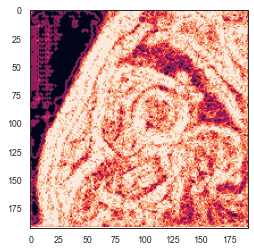

In [71]:
# gt_prob=torch.cat([1-image_tensor, image_tensor],dim=1)
# predict_prob = torch.cat([1-rec, rec],dim=1)
# klv = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean', log_target=False)(input=torch.log(predict_prob),target=gt_prob)
# klv
# https://stackoverflow.com/questions/40596026/what-does-entropy-mean-in-this-context
## measuring mutual information: https://github.com/connorlee77/pytorch-mutual-information
from skimage.filters.rank import entropy
from skimage.morphology import disk
n_slice = rec.size(0)
ent_sum=0
for slice_id in range(n_slice):
    entr_img = entropy(rec.data.cpu().numpy()[slice_id,0], disk(1))
    print(entr_img.mean())
    ent_sum+=entr_img.mean()
print ('average entropy:',ent_sum/n_slice)
plt.imshow(entr_img)
# entr_sty_img = entropy(corrupted_img.data.cpu().numpy()[slice_id,0], disk(5))

In [67]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X=f)
feature_dict = {'tsne-2d-one':tsne_results[:,0],
                'tsne-2d-two': tsne_results[:,1],
                'class':classes }


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.025s...
[t-SNE] Computed neighbors for 20000 samples in 1.356s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

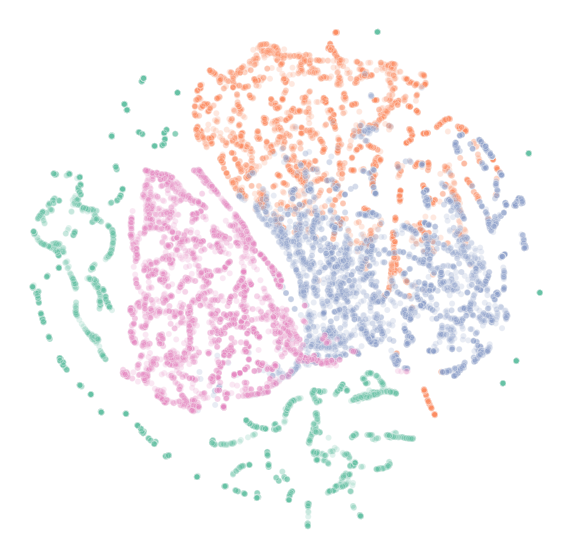

In [70]:
import pandas as pd
df_subset= pd.DataFrame(feature_dict,columns =['tsne-2d-one','tsne-2d-two','class'] )
# plt.figure(figsize=(16,10))

df_subset.loc[df_subset['class']==0,'class'] = 'background'
df_subset.loc[df_subset['class']==1,'class'] = 'left ventricle'
df_subset.loc[df_subset['class']==2,'class'] = 'left ventricular myocardium'
df_subset.loc[df_subset['class']==3,'class'] = 'right ventricle'

plt.figure(figsize=(10,10))
sns.set(font_scale=2.0)
g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("Set2", num_classes),
    data=df_subset,
    legend=False,
    alpha=0.2
)
plt.grid('off')
plt.axis('off')
# Removed 'ax' from T.W.'s answer here aswell:
# box = g.get_position()
# g.set_position([box.x0, box.y0, box.width * 0, box.height]) # resize position

# # Put a legend to the right side
# g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

plt.show()